## CITE-Seq analysis
(adapted from [Processing and integrating 5k PBMCs CITE-seq data by Danila Bredikhin](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html))

- Data availability: [Atlas of Human Breast Cancers](https://singlecell.broadinstitute.org/single_cell/study/SCP1039/a-single-cell-and-spatially-resolved-atlas-of-human-breast-cancers#/)

In [59]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pegasus as pg
import anndata
import warnings
import matplotlib as mpl

from pandas.core.interchange.from_dataframe import primitive_column_to_ndarray
from scanpy.experimental.pp import highly_variable_genes
# os.chdir("../")

sc.settings.verbosity = 0
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=anndata.ImplicitModificationWarning)

In [60]:
msi_output = pd.read_csv("msisensor_pipeline/msisensor_output.csv")
msi_output.set_index('sample_id', inplace = True)

In [61]:
# Data loading
rna_data_path = "data/SCP1039/expression"
rna = sc.read_10x_mtx(rna_data_path)

## Data Filtering

The following code block merely does some data wrangling to parse out our patient of interest from the massive 100K dataset
We make a mask of the original dataframe for downstream analysis.

In [62]:
rna_adata = rna.copy()

# patient barcodes are in obs_names followed by cell barcode
rna_adata.obs['patient'] = rna_adata.obs_names.str.split('_').str[0]
rna_adata.obs['cell_bc'] = rna_adata.obs_names
print("Unique patients:", rna_adata.obs['patient'].unique())

# patients of interest
patient = ["CID3586", "CID3838", "CDI3921", "CID3941", "CID3946", "CID3948", "CID3963", "CID4398", "CID44971"]
patient_mask = rna_adata.obs['patient'].isin(patient)
assert msi_output.index.isin(rna_adata.obs_names).all(), "ID Mismatch!"

masked = rna_adata[patient_mask]
merged_obs = masked.obs.merge(
        msi_output,
        left_on = 'cell_bc',
        right_index = True,
        how = 'left'
)

# Patient Colors
masked.obs['patient'] = masked.obs['patient'].astype('category')
p_categories = masked.obs['patient'].cat.categories
c = sns.color_palette("mako", n_colors = len(p_categories))
patient_colors = dict(zip(p_categories, c))
masked.uns['patient_colors'] = list(patient_colors.values())

masked.obs = merged_obs

Unique patients: ['CID3586' 'CID3921' 'CID45171' 'CID3838' 'CID4066' 'CID44041' 'CID4465'
 'CID4495' 'CID44971' 'CID44991' 'CID4513' 'CID4515' 'CID4523' 'CID3946'
 'CID3963' 'CID4461' 'CID4463' 'CID4471' 'CID4530N' 'CID4535' 'CID4040'
 'CID3941' 'CID3948' 'CID4067' 'CID4290A' 'CID4398']


## Mito and Ribosomal Counts

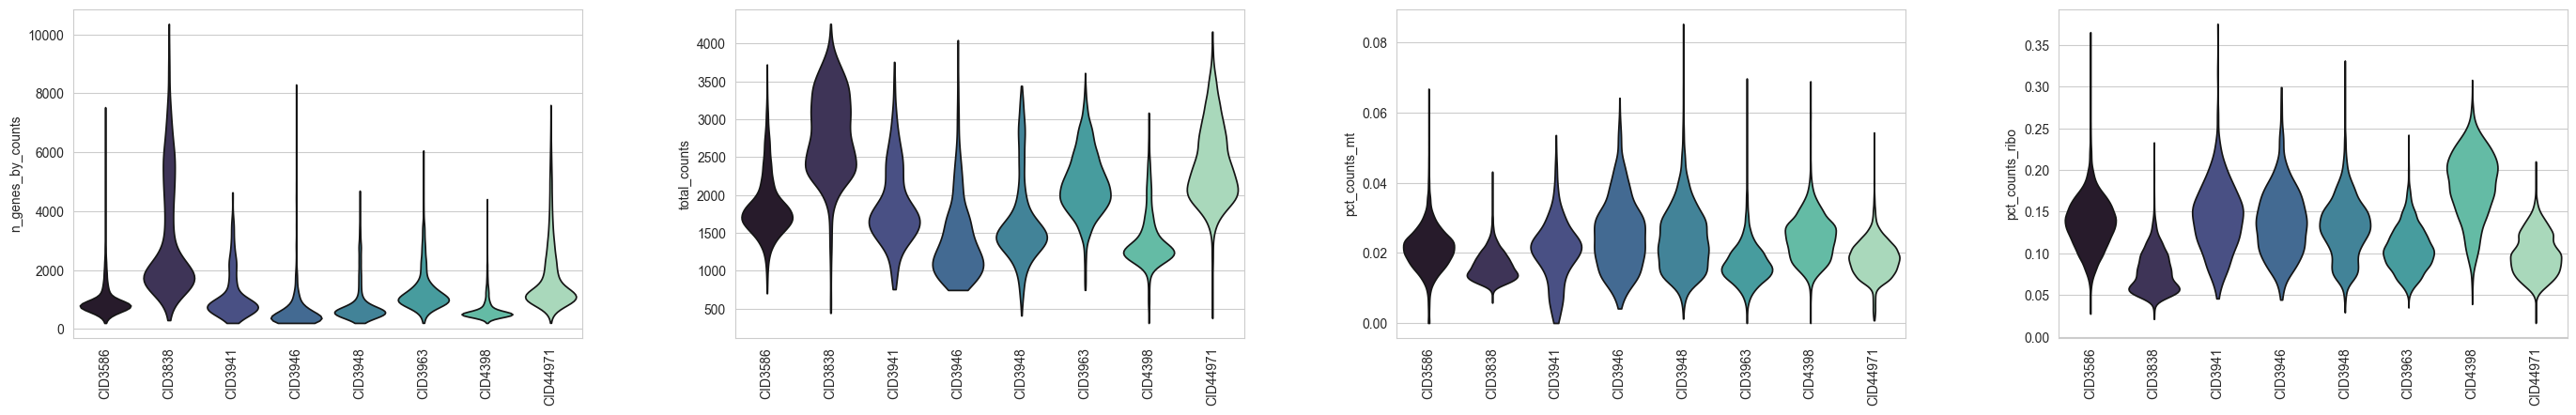

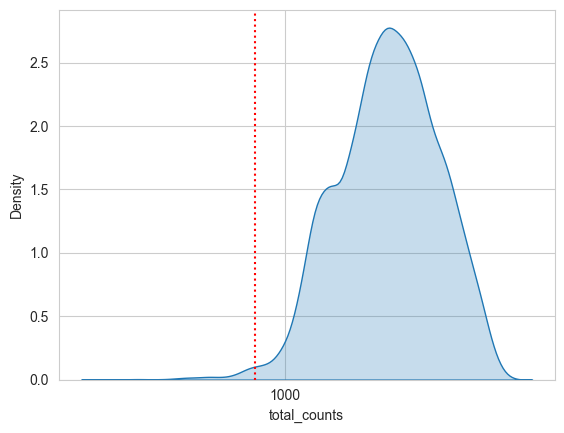

In [63]:
masked_qc = masked.copy()
masked_qc.var['mt'] = masked_qc.var_names.str.startswith('MT-')
masked_qc.var['ribo'] = masked_qc.var_names.str.startswith(('RPS', 'RPL'))

sc.pp.calculate_qc_metrics(
    masked_qc, 
    qc_vars=['mt','ribo'],
    percent_top=None,
    log1p=False,
    inplace=True,
)

masked_qc.obs.pct_counts_mt = masked_qc.obs.pct_counts_mt/100
masked_qc.obs.pct_counts_ribo = masked_qc.obs.pct_counts_ribo/100

sc.pl.violin(masked_qc,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             color = patient_colors,
             groupby = 'patient',
             rotation=90, stripplot=False,
             save = 'cell_type.png')

density = sns.kdeplot(masked_qc.obs['total_counts'], shade=True, log_scale=True)
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(825, color='red', linestyle=':')
plt.savefig("figures/total_counts.kdeplot.raw.png")
plt.show()

## QC Filtering

The following code performs QC and clustering on the masked dataset
1. Here filtration for the ribosomal and mitochondrial expression is performed
2. first we filter genes that do not contain at least 10 cells
3. and we filter cells that contain between 200 and 2500 counts, excluding empty drops and doublets.
4. Then we normalize the total genes and perform log1p scaling
5. Then we filter the genes that are highly variable in the subsetThis subset of data is used to perform dimensionality reduction and leiden clustering

Total number of cells: 28227
Number of cells after MT filter: 28208
Number of cells after Ribo filter: 21135
Number of cells after Count filter: 17859
Number of cells after Count filter: 17859


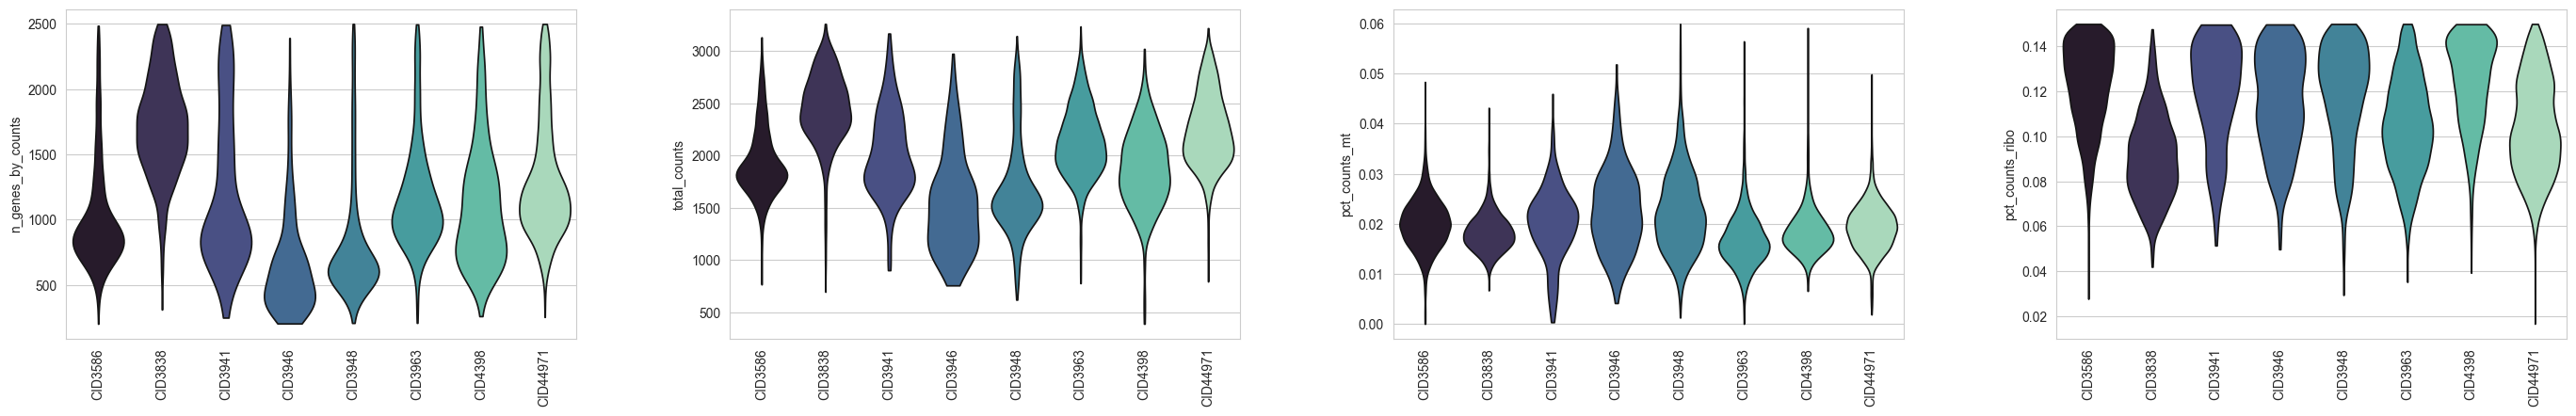

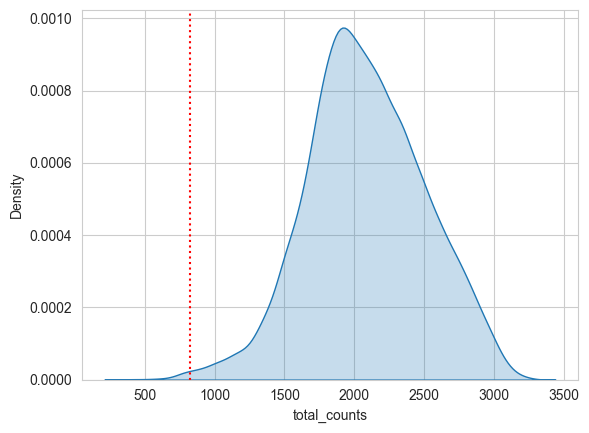

In [64]:
patient_filtered = masked_qc.copy()

max_mt_ratio = 0.06
max_ribo_ratio = 0.15
max_counts = 2500
min_counts = 200
min_cells = 10
min_genes = 200

sc.pp.calculate_qc_metrics(patient_filtered, inplace=True)
print(f'Total number of cells: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.pct_counts_mt < max_mt_ratio]
print(f'Number of cells after MT filter: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.pct_counts_ribo < max_ribo_ratio]
print(f'Number of cells after Ribo filter: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.n_genes_by_counts < max_counts]
print(f'Number of cells after Count filter: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.n_genes_by_counts > min_counts]
print(f'Number of cells after Count filter: {patient_filtered.n_obs:d}')

# filter and normalize
sc.pp.highly_variable_genes(patient_filtered, n_top_genes=2000)
sc.pp.filter_genes(patient_filtered, min_cells = 10)
sc.pp.normalize_total(patient_filtered, target_sum = 1e4)
sc.pp.log1p(patient_filtered)

# highest genes
rna_hvg = patient_filtered[:, patient_filtered.var.highly_variable]
sc.pp.scale(rna_hvg, max_value = 10)

# dimensionality reduction
sc.pp.pca(rna_hvg, n_comps = 50)
sc.pp.neighbors(rna_hvg, n_neighbors = 16, n_pcs = 30)

# clustering
sc.tl.leiden(rna_hvg, resolution = 0.5, flavor = "igraph", n_iterations = 2)
sc.tl.umap(rna_hvg)

# copy back to dataset
patient_filtered.obs['leiden'] = rna_hvg.obs['leiden']

sc.pl.violin(patient_filtered,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             color = patient_colors,
             groupby = 'patient',
             rotation=90, stripplot=False,
             save = 'cell_type.png')

density = sns.kdeplot(patient_filtered.obs['total_counts'], shade=True, log_scale=False)
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(825, color='red', linestyle=':')
plt.savefig("figures/total_counts.kdeplot.filtered.png")

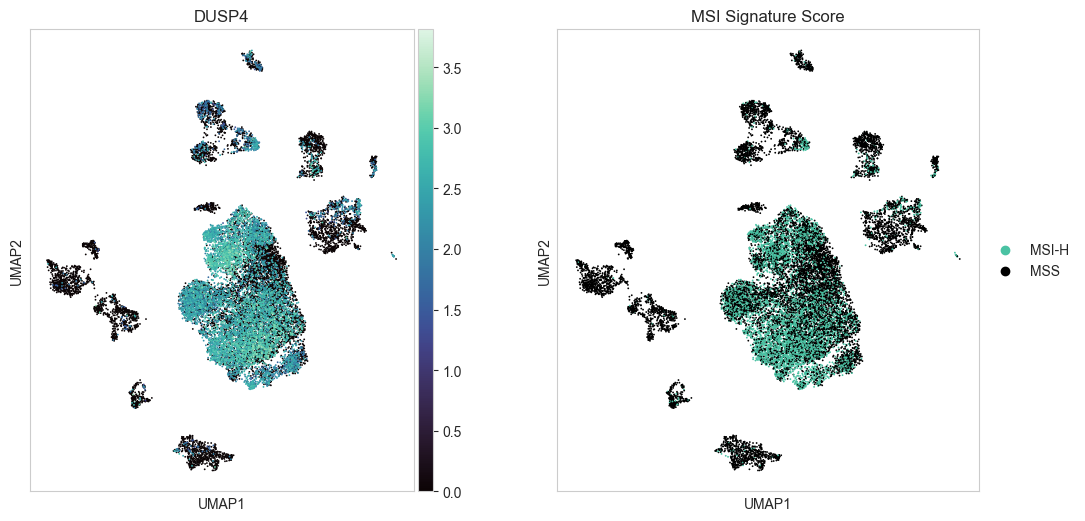

In [65]:
ncols = 2
nrows = 1
figsize = 6  # Base size for each subplot
wspace = 0.25  # Space between subplots

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + wspace * (ncols - 1), nrows * figsize)
)
plt.subplots_adjust(wspace=wspace) 

rna_filtered = patient_filtered.copy()

# Re-run analysis on this subset
sc.pp.neighbors(rna_filtered, n_neighbors = 12, n_pcs = 30)
sc.tl.leiden(rna_filtered, resolution = 0.5)

sc.tl.umap(rna_filtered)
sc.pl.umap(rna_filtered, color = 'leiden', palette = 'mako')

cell surface (and msi identified) markers for clustering
rna_markers = ['CD4', 'CD8', 'CD8A', 'CD55', 'CD79A',
               'CD3D', 'CD86', 'CD44', 'DUSP4', 'MSH-1']
sc.set_figure_params(figsize=(8, 8))
rna_markers = ['DUSP4']
markers_in_data = [m for m in rna_markers if m in rna_filtered.var_names]
sc.pl.umap(rna_filtered, color = markers_in_data, cmap = 'mako', ax=axs[0], show = False)

sc.pl.umap(rna_for_de,
           color = 'msi_status',
           color_map = 'mako',
           palette = ("#4AC2A3", "#000000"),
           title = 'MSI Signature Score', ax=axs[1])


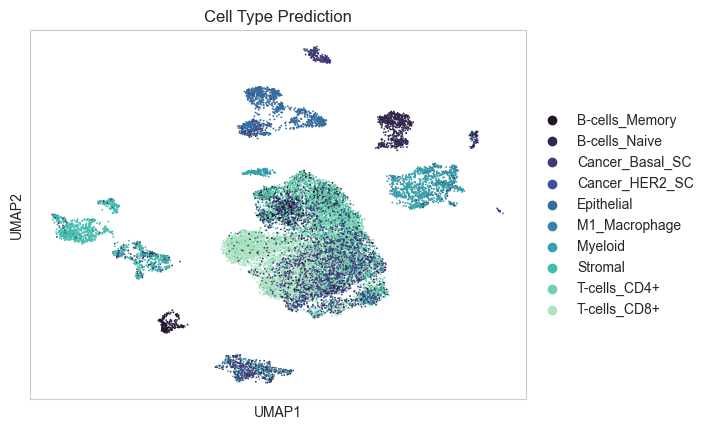

In [66]:
cell_markers = {
    'B-cells_Memory' : ['CD79A', 'MS4A1', 'CD27', 'CD80', 'CD86', 'IGHG1'],
    'B-cells_Naive'  : ['CD79A', 'MS4A1', 'IgD', 'CD38lo', 'CD27-', 'IGHM'],
    'Cancer_Basal_SC': ['CD271', 'p63', 'KRT5', 'KRT17', 'VIM', 'ITGA1'],
    'Cancer_HER2_SC' : ['CD44', 'CD24-', 'ALDH1', 'ERBB2', 'EGR1', 'MUC1'],
    'Epithelial'     : ['KRT18', 'KRT19', 'EPCAM', 'KRT8', 'CDH1', 'MUC1'],
    'M1_Macrophage'  : ['NOS2', 'IL-1β', 'IL-6', 'TNF-α', 'IFN-γ', 'CD80', 'CD86'],
    'Myeloid'        : ['CD14', 'LYZ', 'CSF1R', 'CD11b', 'CD11c', 'CD16', 'HLA-DR'],
    'Stromal'        : ['COL1A1', 'FAP', 'ACTA2', 'PDGFRA', 'PDGFRB', 'VIM', 'CXCL12'],
    'T-cells_CD4+'   : ['CD3D', 'CD4', 'IL7R', 'CXCR3', 'CCR4', 'CCR6'],
    'T-cells_CD8+'   : ['CD3D', 'CD8A', 'CD8B', 'GZMA', 'PRF1', 'GZMB', 'TBX21'],
}

# cell type scores
for cell_type, markers in cell_markers.items():
    markers_in_data = [m for m in markers if m in rna_filtered.var_names]
    if markers_in_data:
        sc.tl.score_genes(rna_filtered, markers_in_data, score_name = f'{cell_type}_score')

# predicted cell type
cell_type_columns = [f'{ct}_score' for ct in cell_markers.keys() if f'{ct}_score' in rna_filtered.obs.columns]
rna_filtered.obs['predicted_celltype'] = rna_filtered.obs[cell_type_columns].idxmax(axis = 1)
rna_filtered.obs['predicted_celltype'] = rna_filtered.obs['predicted_celltype'].str.replace('_score', '')

# cell type palette assignment
c = sns.color_palette("mako", n_colors = len(cell_markers.keys()), desat = 1)
celltype_colors = dict(zip(cell_markers.keys(), c))

# Plot a single UMAP with cell types as colors
sc.pl.umap(rna_filtered,
           color = 'predicted_celltype',
           palette = celltype_colors,
           title = 'Cell Type Prediction')

## Rank Gene Groups

Identifying clusters of genes that are differentially expressed can characterize the cell type for the heterogeneous cell population.

The following code ranks the gene groups and generates a heatmap based on the cluster grouping and differential expression.
Key points:
- We use the `pts=True` function in the `rank_gene_groups` to calculate percentage of cells expressing the genes.
- We use the `tie_correct=True` function to gain more accurate p-values for expression enrichment.

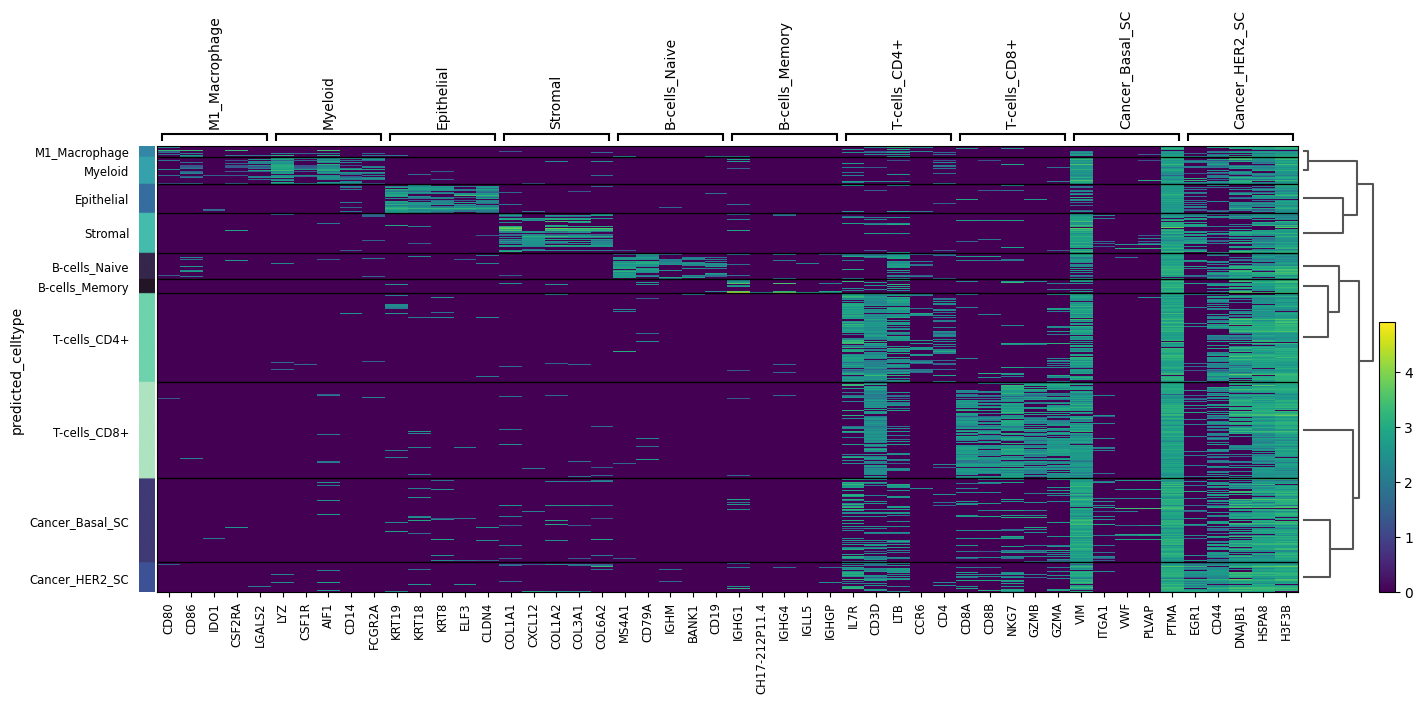

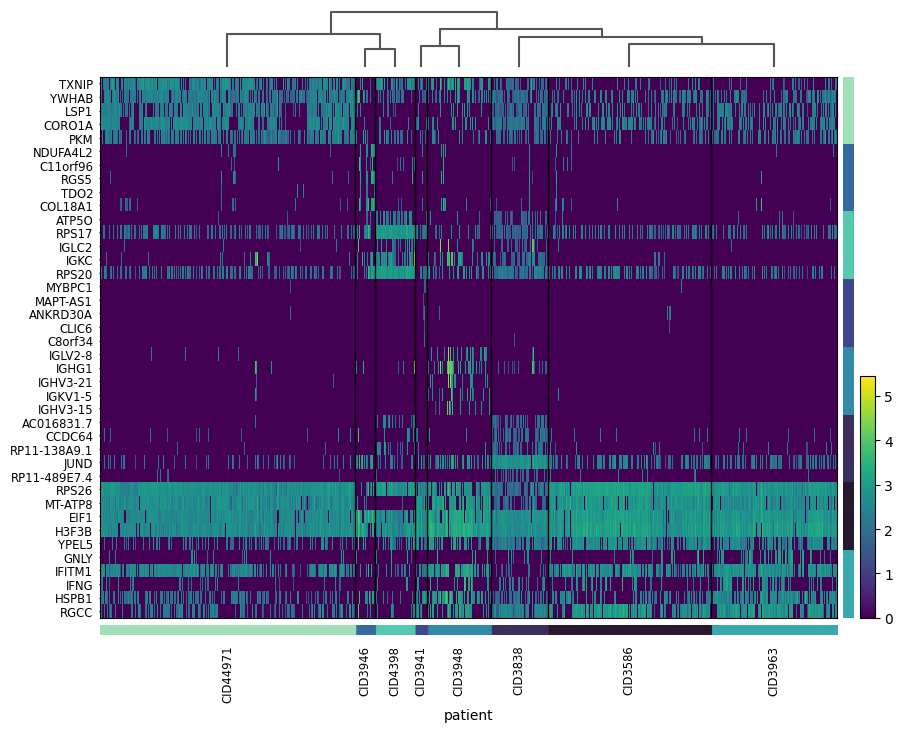

In [361]:
rna_for_de = rna_filtered.copy()
# explicitly use raw or log-normal data. helps with the scaling
if 'raw' in rna_filtered.__dict__ and rna_filtered.raw is not None:
    rna_for_de = rna_filtered
    use_raw = True
else:
    rna_for_de = rna_filtered
    use_raw = False

# rank gene groups.
sc.tl.rank_genes_groups(rna_for_de, 'predicted_celltype',
                        method = 'wilcoxon',
                        use_raw = use_raw,
                        pts = True,
                        tie_correct = True)

sc.pl.rank_genes_groups_heatmap(rna_for_de, n_genes = 5,
                                groupby = 'predicted_celltype',
                                show_gene_labels = True,
                                dendrogram = True)

sc.tl.rank_genes_groups(rna_for_de, 'patient',
                        method = 'wilcoxon',
                        use_raw = use_raw,
                        pts = True,
                        tie_correct = True)

sc.pl.rank_genes_groups_heatmap(rna_for_de, n_genes = 5,
                                groupby = 'patient',
                                show_gene_labels = True,
                                swap_axes = True,
                                dendrogram = True)

In [282]:
# alternate ranking of genes
sc.tl.rank_genes_groups(rna_for_de, 'leiden',
                        method = 'wilcoxon',
                        use_raw = use_raw,
                        key_added = 'wilcoxon_fixed',
                        pts = True,
                        min_in_group_fraction = 0.1,
                        min_fold_change = 1.5)


The final part of the expression analysis is performing the neighbors clustering on the highly differentiated genes. What is nice about this is we get better subcluster resolution than against the whole data
Ultimately this is most useful for identifying any subclusters that have differentially expressed CDs that can be used for our MSI model prediction.

In [285]:
import scanpy as sc
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

rna_for_ml = rna_for_de.copy()

# gene features and msi_status
X = rna_for_ml.X
y = np.where(rna_for_ml.obs['msi_status'] == 'MSI-H', 1, 0)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.18,
                                                    random_state=101,
                                                    stratify=y)

# train
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param["eval_metric"] = "error"
param['max_depth'] = 6
param['min_child_weight']=1
param['max_delta_step'] = 0
param['subsample']= 1
param['colsample_bytree']=1
param['seed'] = 101
param['base_score'] = 0.5
param['early_stopping_rounds'] = 10

model = xgb.XGBClassifier(**param)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=True)

# evaluate
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# features
importance = model.feature_importances_
feature_names = rna_for_de.var_names
top_genes = pd.DataFrame({'feature': feature_names, 
                         'importance': importance}).sort_values('importance', 
                                                              ascending=False).head(20)


[0]	validation_0-error:0.09549
[1]	validation_0-error:0.08336
[2]	validation_0-error:0.08523
[3]	validation_0-error:0.08398
[4]	validation_0-error:0.08025
[5]	validation_0-error:0.07745
[6]	validation_0-error:0.07621
[7]	validation_0-error:0.07527
[8]	validation_0-error:0.07403
[9]	validation_0-error:0.07123
[10]	validation_0-error:0.07247
[11]	validation_0-error:0.07123
[12]	validation_0-error:0.06656
[13]	validation_0-error:0.06687
[14]	validation_0-error:0.06345
[15]	validation_0-error:0.06283
[16]	validation_0-error:0.06314
[17]	validation_0-error:0.06159
[18]	validation_0-error:0.05972
[19]	validation_0-error:0.05879
[20]	validation_0-error:0.05785
[21]	validation_0-error:0.05785
[22]	validation_0-error:0.05661
[23]	validation_0-error:0.05661
[24]	validation_0-error:0.05537
[25]	validation_0-error:0.05350
[26]	validation_0-error:0.05163
[27]	validation_0-error:0.05194
[28]	validation_0-error:0.05194
[29]	validation_0-error:0.05257
[30]	validation_0-error:0.05226
[31]	validation_0-

        feature  importance
8113      DUSP4    0.045036
3240       MLH1    0.009029
16330    TNFSF9    0.008946
10678     CH25H    0.008912
2318       GNLY    0.008839
3239   EPM2AIP1    0.007056
2896     SPAG16    0.006472
6517     CARD11    0.005902
7481       CYBB    0.005872
16171     HMHA1    0.005834
3510    C3orf14    0.005666
16941     RPS19    0.005535
1805       GNG4    0.005491
16757     FXYD1    0.005418
3885       MLF1    0.005130
10967     NINJ2    0.005026
6325    TNFAIP3    0.005021
19     TNFRSF18    0.004720
3988      TRA2B    0.004489
10351    CAMK1D    0.004317


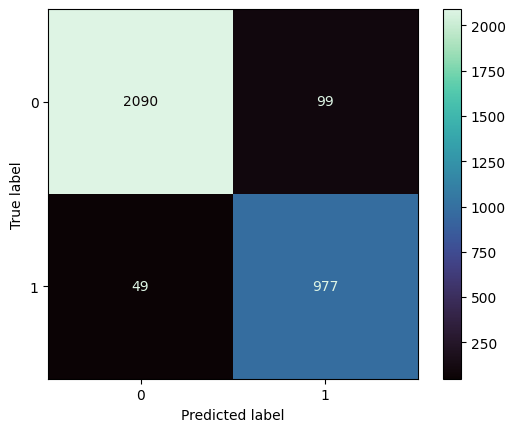

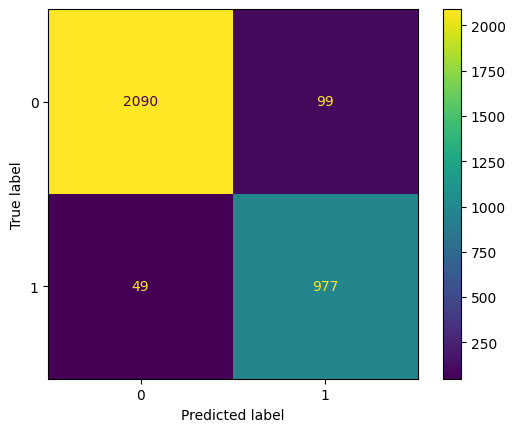

<Figure size 1200x1000 with 0 Axes>

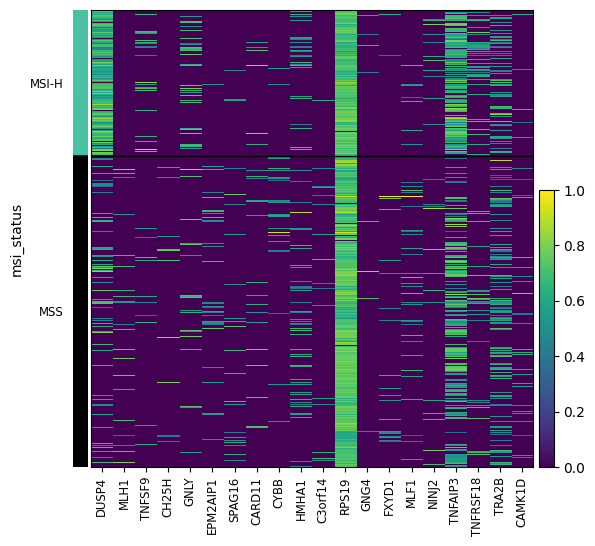

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
xgb_markers = top_genes['feature'].to_list()
print(top_genes)

plt.figure(figsize = (12, 10))
sc.pl.heatmap(rna_filtered, xgb_markers, groupby = 'msi_status',
              dendrogram = False, standard_scale = 'var',
              swap_axes = False, show_gene_labels = True)


sns.reset_orig() 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'mako')
disp.plot()


Predicting MSI is the main feature of this code. We can subset the rna_filtered adata frame to more specifically score the individual cells based on their expression of a few marker genes.


['DUSP4', 'GNLY', 'TNFSF9']


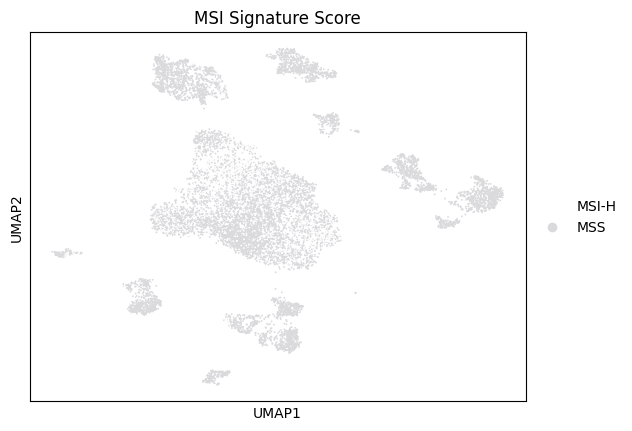

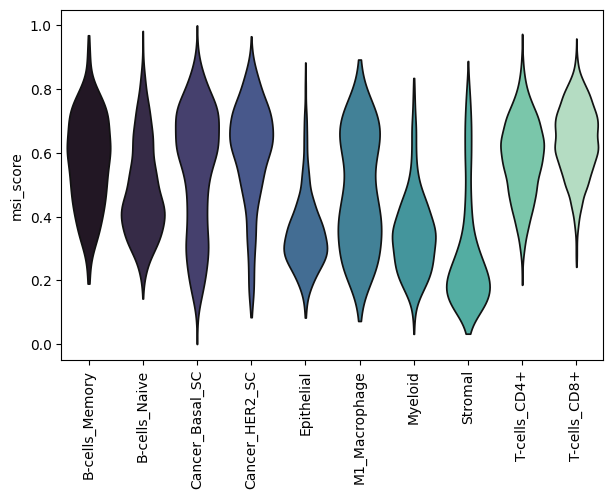

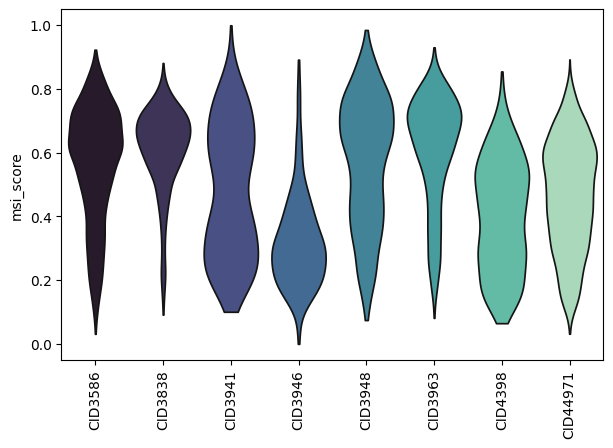

In [364]:
rna_for_de = rna_filtered

# this ranks the genes for msi_status as predicted by msi-sensor
sc.tl.rank_genes_groups(rna_for_de, groupby='msi_status', method='wilcoxon')

# filter for genes with |log2FC| > 1 and adjusted p < 0.05
sc.tl.filter_rank_genes_groups(
        rna_for_de,
        min_fold_change = 2,
        min_in_group_fraction = 0.1,
        max_out_group_fraction = 0.75,
        compare_abs = True
)

# what genes are deg in MSI-H
de_df = sc.get.rank_genes_groups_df(
        rna_for_de,
        group = 'MSI-H',
        key = 'rank_genes_groups_filtered'
).dropna(subset = ['names'])

top_genes = de_df.head(10)['names'].tolist()
print(top_genes) 


# MSI correlates with immune infiltration
# Compare MSI with stromal/immune components
tme_markers = {'immune_up' : ['CD3D', 'CD8A', 'CD8B', 'GZMA', 'HLA-DRA', 'CD74', 'CCL5'],
               'immune_down' : ['COL1A1', 'SPARC', 'CALD1'],
               'msi_up' : ['DUSP4', 'DUSP2', 'CST7', 'TNFAIP3',],
               'msi_down' : ['CST3','MGP',"GSN",'NPC2','TIMP1', 'MLH1'],
               'stromal': ['SPARCL1', 'SPARC', 'COL1A1', 'CALD1']}

rna_for_de.layers['inverted'] = -rna_for_de.X

for tme, markers in tme_markers.items():
    markers_in_data = [m for m in markers if m in rna_filtered.var_names]
    if markers_in_data:
        if "down" in tme:
            sc.tl.score_genes(rna_for_de, markers_in_data, layer='inverted', score_name=f'{tme}_score')
        else:
            sc.tl.score_genes(rna_filtered, markers_in_data, score_name = f'{tme}_score')

# downregulated Marker Genes
 

rna_for_de.obs['msi_score'] = (
    rna_for_de.obs['msi_up_score'] + 
    rna_for_de.obs['msi_down_score']
)

min_score = rna_for_de.obs['msi_score'].min()
max_score = rna_for_de.obs['msi_score'].max()
rna_for_de.obs['msi_score'] = (
    (rna_for_de.obs['msi_score'] - min_score) / (max_score - min_score)
)

rna_for_de.obs['immune_score'] = (
    rna_for_de.obs['immune_up_score'] + 
    rna_for_de.obs['immune_down_score']
)

min_score = rna_for_de.obs['immune_score'].min()
max_score = rna_for_de.obs['immune_score'].max()
rna_for_de.obs['immune_score'] = (
    (rna_for_de.obs['immune_score'] - min_score) / (max_score - min_score)
)
# we make our own panel scoring from several data sources

#['WRN', 'MLH1', 'MSH2', 'MSH3', 'MSH6', # well-characterized msi-genes
              # generated from differential expression
             #'TP53', 'PIK3CA', 'ESR1', 'ASM'] # cancer activation pathways


sc.pl.umap(rna_for_de,
           color = 'msi_status',
           color_map = 'mako',
           palette = ("#FFFFFF", "#DADADD"),
           title = 'MSI Signature Score')

sc.pl.violin(rna_for_de, 'msi_score',
             groupby = 'predicted_celltype',
             rotation = 90,
             palette = celltype_colors,
             hue = 'predicted_celltype',
             stripplot = False)

sc.pl.violin(rna_for_de, 'msi_score',
             groupby = 'patient',
             rotation = 90,
             palette = patient_colors,
             stripplot = False)

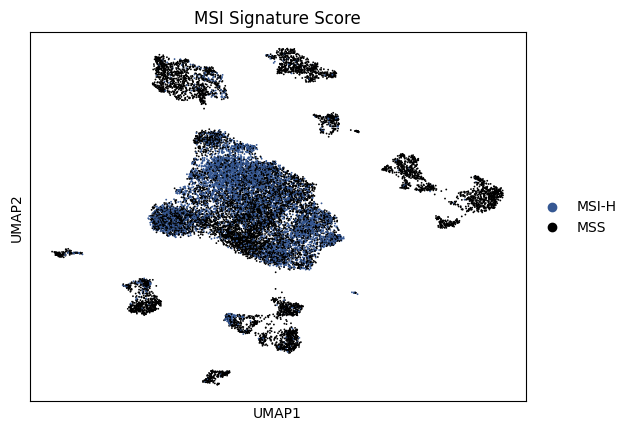

In [330]:
sc.pl.umap(rna_for_de,
           color = 'msi_status',
           color_map = 'mako',
           palette = ("#365893", "#000000"),
           title = 'MSI Signature Score')

['MSS', 'MSI-H']
Categories (2, object): ['MSI-H', 'MSS']
      names     scores  logfoldchanges          pvals      pvals_adj
0     DUSP4  83.333817        4.016279   0.000000e+00   0.000000e+00
1     DUSP2  33.665024        1.386012  1.879671e-248  1.731553e-244
2      CST7  33.496498        1.656348  5.420014e-246  3.328611e-242
3   TNFAIP3  33.149212        1.348206  5.813219e-241  2.677569e-237
4      RGCC  33.022247        1.344808  3.894506e-239  1.435048e-235
5      SRGN  32.265739        1.111487  2.116229e-228  6.498234e-225
6      CCL5  31.798922        1.491576  6.699231e-222  1.763238e-218
7      NKG7  30.301348        1.775128  1.100443e-201  2.534320e-198
8      CREM  29.661600        1.311576  2.403354e-193  4.919933e-190
9      SOD1  29.416328        0.817809  3.395550e-190  6.255961e-187
10   SAMSN1  27.995163        1.422627  1.860771e-172  3.116623e-169
11     CCL4  27.786587        1.596065  6.300362e-170  9.673156e-167
12     CD69  27.695086        1.208884  8.001

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

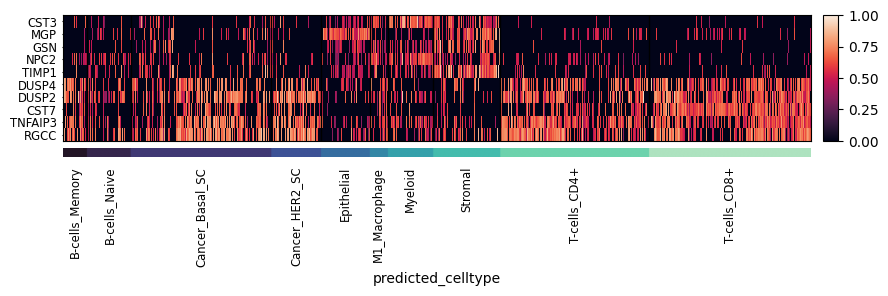

<Figure size 1200x1000 with 0 Axes>

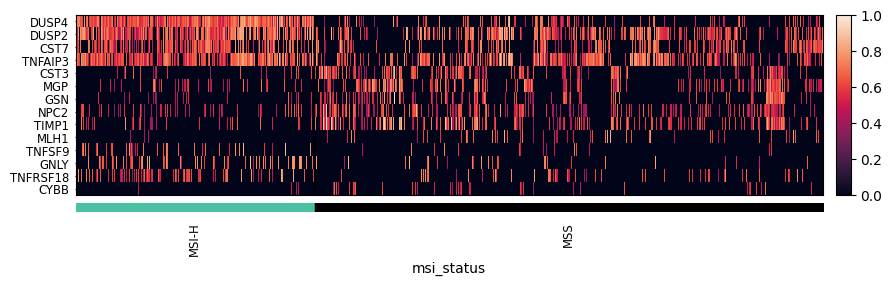

<Figure size 1200x1000 with 0 Axes>

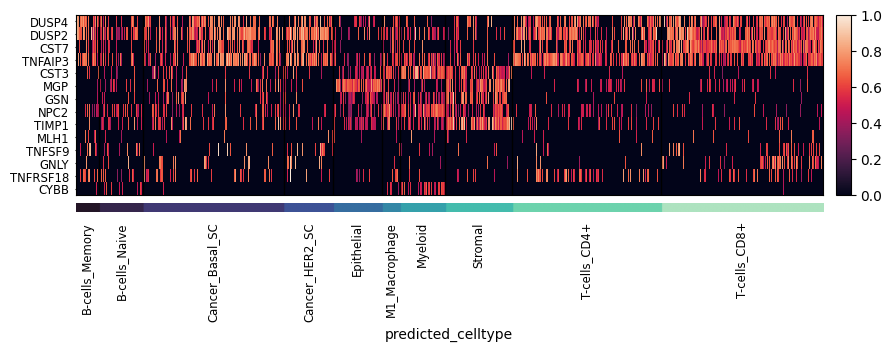

['DUSP4', 'DUSP2', 'CST7', 'TNFAIP3', 'CST3', 'MGP', 'GSN', 'NPC2', 'TIMP1', 'MLH1']
['DUSP4', 'DUSP2', 'CST7', 'TNFAIP3', 'CST3', 'MGP', 'GSN', 'NPC2', 'TIMP1', 'MLH1']


In [79]:
rna_filtered = rna_for_de

sc.tl.rank_genes_groups(rna_filtered, groupby='msi_status', method='wilcoxon')

marker_genes = []
cell_types = rna_filtered.obs['msi_status'].unique()
print(cell_types)
for i in cell_types:
    markers_df = sc.get.rank_genes_groups_df(rna_for_de, group = str(i))
    filtered_markers = markers_df[(markers_df['pvals_adj'] < 0.05) &
                                  (markers_df['logfoldchanges'].abs() > 1)]
    if not filtered_markers.empty:
        marker_genes.extend(filtered_markers['names'][:5].tolist())  # Top 5 genes per cluster

print(markers_df.iloc[0:25])
# marker gene heatmap
if marker_genes:
    plt.figure(figsize = (12, 10))
    sc.pl.heatmap(rna_filtered, marker_genes, groupby = 'predicted_celltype',
                  dendrogram = False, standard_scale = 'var',
                  swap_axes = True, show_gene_labels = True, cmap ='rocket')
    
if tme_markers['msi_up'] + tme_markers['msi_down']:
    plt.figure(figsize = (12, 10))
    sc.pl.heatmap(rna_filtered, tme_markers['msi_up'] + tme_markers['msi_down'] + ['TNFSF9', 'GNLY', 'TNFRSF18', 'CYBB'], groupby = 'msi_status',
                  dendrogram = False, standard_scale = 'var',
                  swap_axes = True, show_gene_labels = True, cmap ='rocket')
    

if tme_markers['msi_up'] + tme_markers['msi_down']:
    plt.figure(figsize = (12, 10))
    sc.pl.heatmap(rna_filtered, tme_markers['msi_up'] + tme_markers['msi_down'] + ['TNFSF9', 'GNLY', 'TNFRSF18', 'CYBB'], groupby = 'predicted_celltype',
                  dendrogram = False, standard_scale = 'var',
                  swap_axes = True, show_gene_labels = True, cmap ='rocket')

print(tme_markers['msi_up'] + tme_markers['msi_down'])

print(tme_markers['msi_up'] + tme_markers['msi_down'])

<Figure size 1200x1000 with 0 Axes>

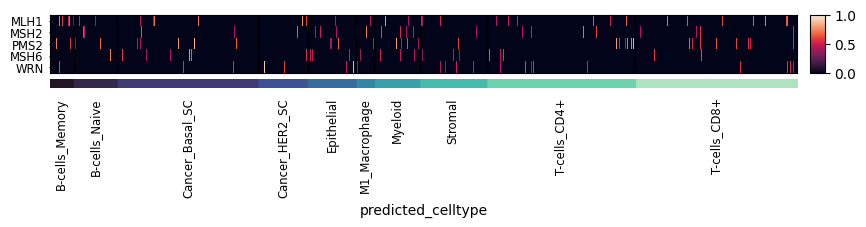

In [85]:
plt.figure(figsize = (12, 10))
sc.pl.heatmap(rna_filtered, ['MLH1', 'MSH2', 'PMS2', 'MSH6', 'WRN'], groupby = 'predicted_celltype',
                  dendrogram = False, standard_scale = 'var',
                  swap_axes = True, show_gene_labels = True, cmap ='rocket')

In [326]:
rna_filtered.obs['msi_status'] = rna_filtered.obs['msi_status'].astype('category')
sc.tl.rank_genes_groups(
    rna_filtered, 
    groupby='msi_status', 
    reference='rest', 
    method='wilcoxon'
)

# pegasus
pg.de_analysis(rna_filtered, cluster='msi_status')
pg.volcano(
    rna_filtered,  
    cluster_id='MSI-H',
    de_key='de_res',
    de_test='mwu',
    qval_threshold=0.05,
    log2fc_threshold=1.0, dpi=300
)

2025-04-03 08:41:50,264 - pegasus.tools.diff_expr - INFO - CSR matrix is converted to CSC matrix. Time spent = 0.1073s.
2025-04-03 08:41:56,805 - pegasus.tools.diff_expr - INFO - MWU test and AUROC calculation are finished. Time spent = 6.5414s.
2025-04-03 08:41:56,864 - pegasus.tools.diff_expr - INFO - Sufficient statistics are collected. Time spent = 0.0582s.
2025-04-03 08:41:56,875 - pegasus.tools.diff_expr - INFO - Differential expression analysis is finished.
2025-04-03 08:41:56,882 - pegasus.tools.diff_expr - INFO - Function 'de_analysis' finished in 6.86s.


The Tumor microenvironment (TME) is made up a variety of components including extracellular matrix, cells that are not malignant (such as immune and stromal cells) and cancer cells.
Characterizing the TME is individualized to a patient as this makeup can be fairly heterogeneous from patient to patient. There are immune checkpoint inhibitors (ICI) and CAR-T therapies that respond better to patients with a certain tumor make-up. 

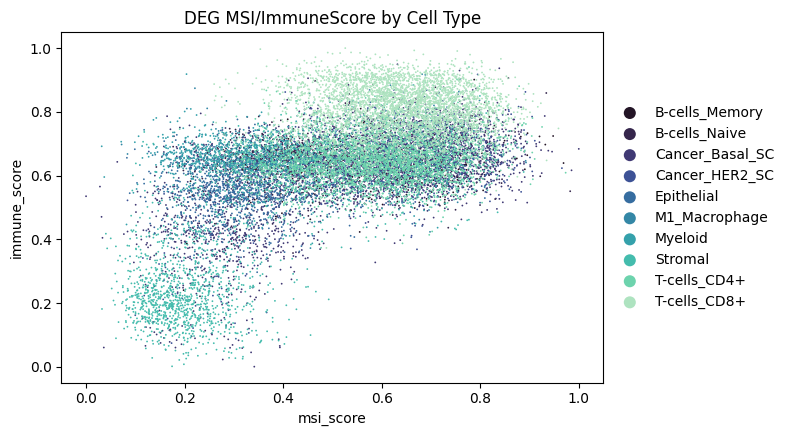

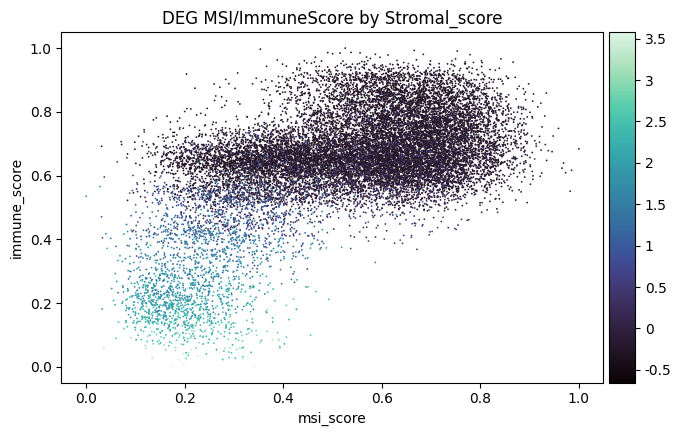

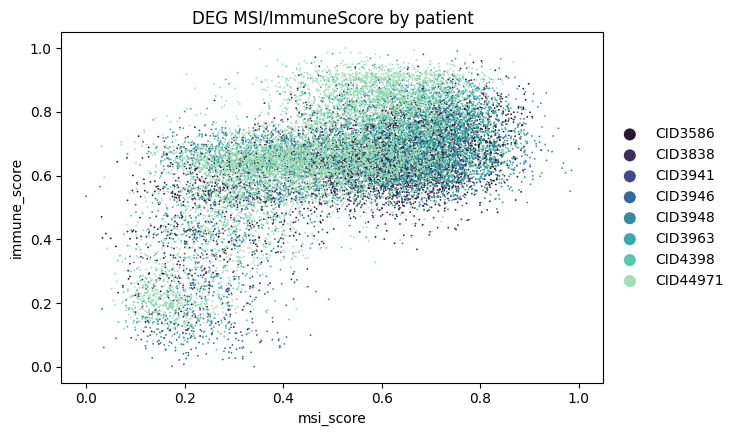

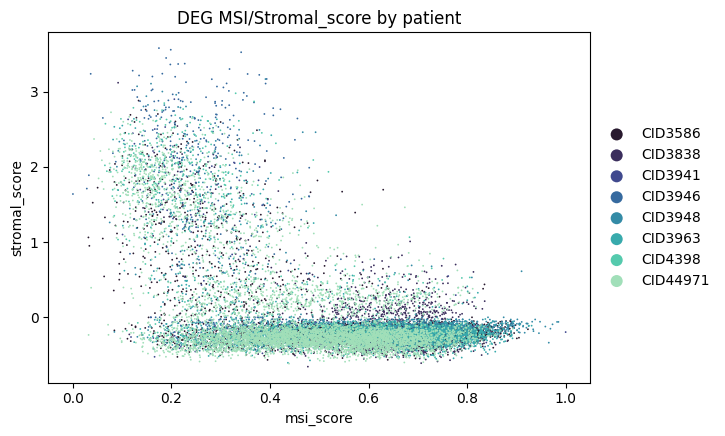

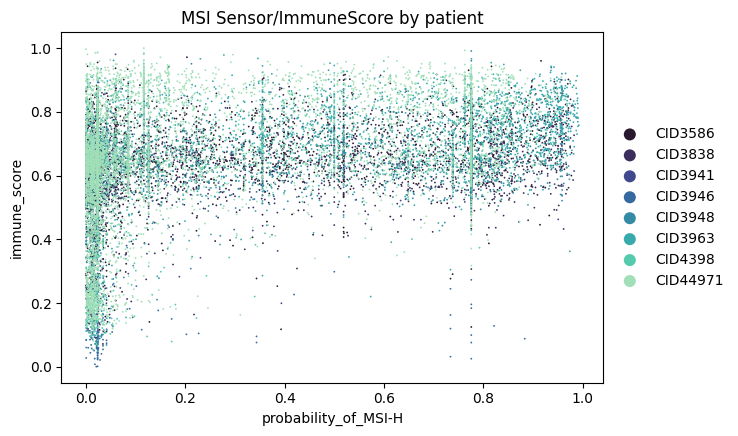

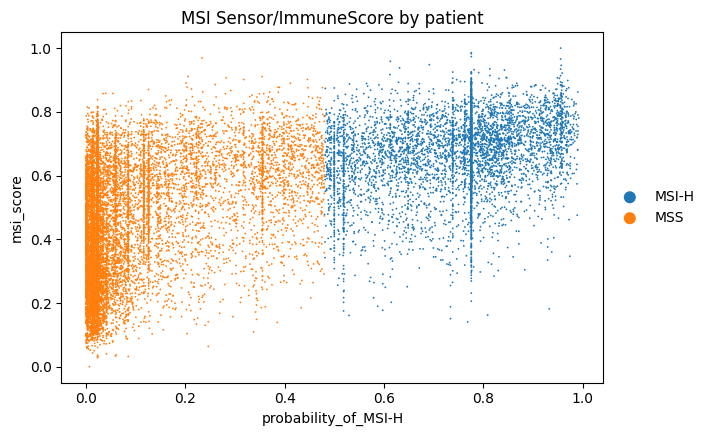

In [325]:
import numpy as np

sc.pl.scatter(rna_filtered, x = 'msi_score', y = 'immune_score', color = 'predicted_celltype',
              title = 'DEG MSI/ImmuneScore by Cell Type')
sc.pl.scatter(rna_filtered, x = 'msi_score', y = 'immune_score', color = 'stromal_score', color_map = 'mako',
              title = 'DEG MSI/ImmuneScore by Stromal_score')
sc.pl.scatter(rna_filtered, x = 'msi_score', y = 'immune_score', color = 'patient', color_map = 'mako',
              title = 'DEG MSI/ImmuneScore by patient')
sc.pl.scatter(rna_filtered, x = 'msi_score', y = 'stromal_score', color = 'patient', color_map = 'mako',
              title = 'DEG MSI/Stromal_score by patient')
sc.pl.scatter(rna_filtered, x = 'probability_of_MSI-H', y = 'immune_score', color = 'patient', color_map = 'mako',
              title = 'MSI Sensor/ImmuneScore by patient')
sc.pl.scatter(rna_filtered, x = 'probability_of_MSI-H', y = 'msi_score', color = 'msi_status', color_map = 'mako',
              title = 'MSI Sensor/ImmuneScore by patient')

df = pd.DataFrame({
    'msi_score': rna_filtered.obs['msi_score'],
    'stromal_score': rna_filtered.obs['stromal_score'],
    'immune_score': rna_filtered.obs['immune_score'],
    'probability_of_MSI-H': rna_filtered.obs['probability_of_MSI-H'],
    'msi_status': rna_filtered.obs['msi_status']
})
df.to_csv("output/sc_rna_scores.csv")

In [ ]:
# Additional UMAP plots
sc.pl.umap(rna_filtered,
           color = 'patient',
           title = "Patient - UMAP",
           cmap = 'mako')
sc.pl.umap(rna_filtered,
           color = 'MSI_score',
           title = "MSI Score from DEG - UMAP", 
           cmap = 'mako')

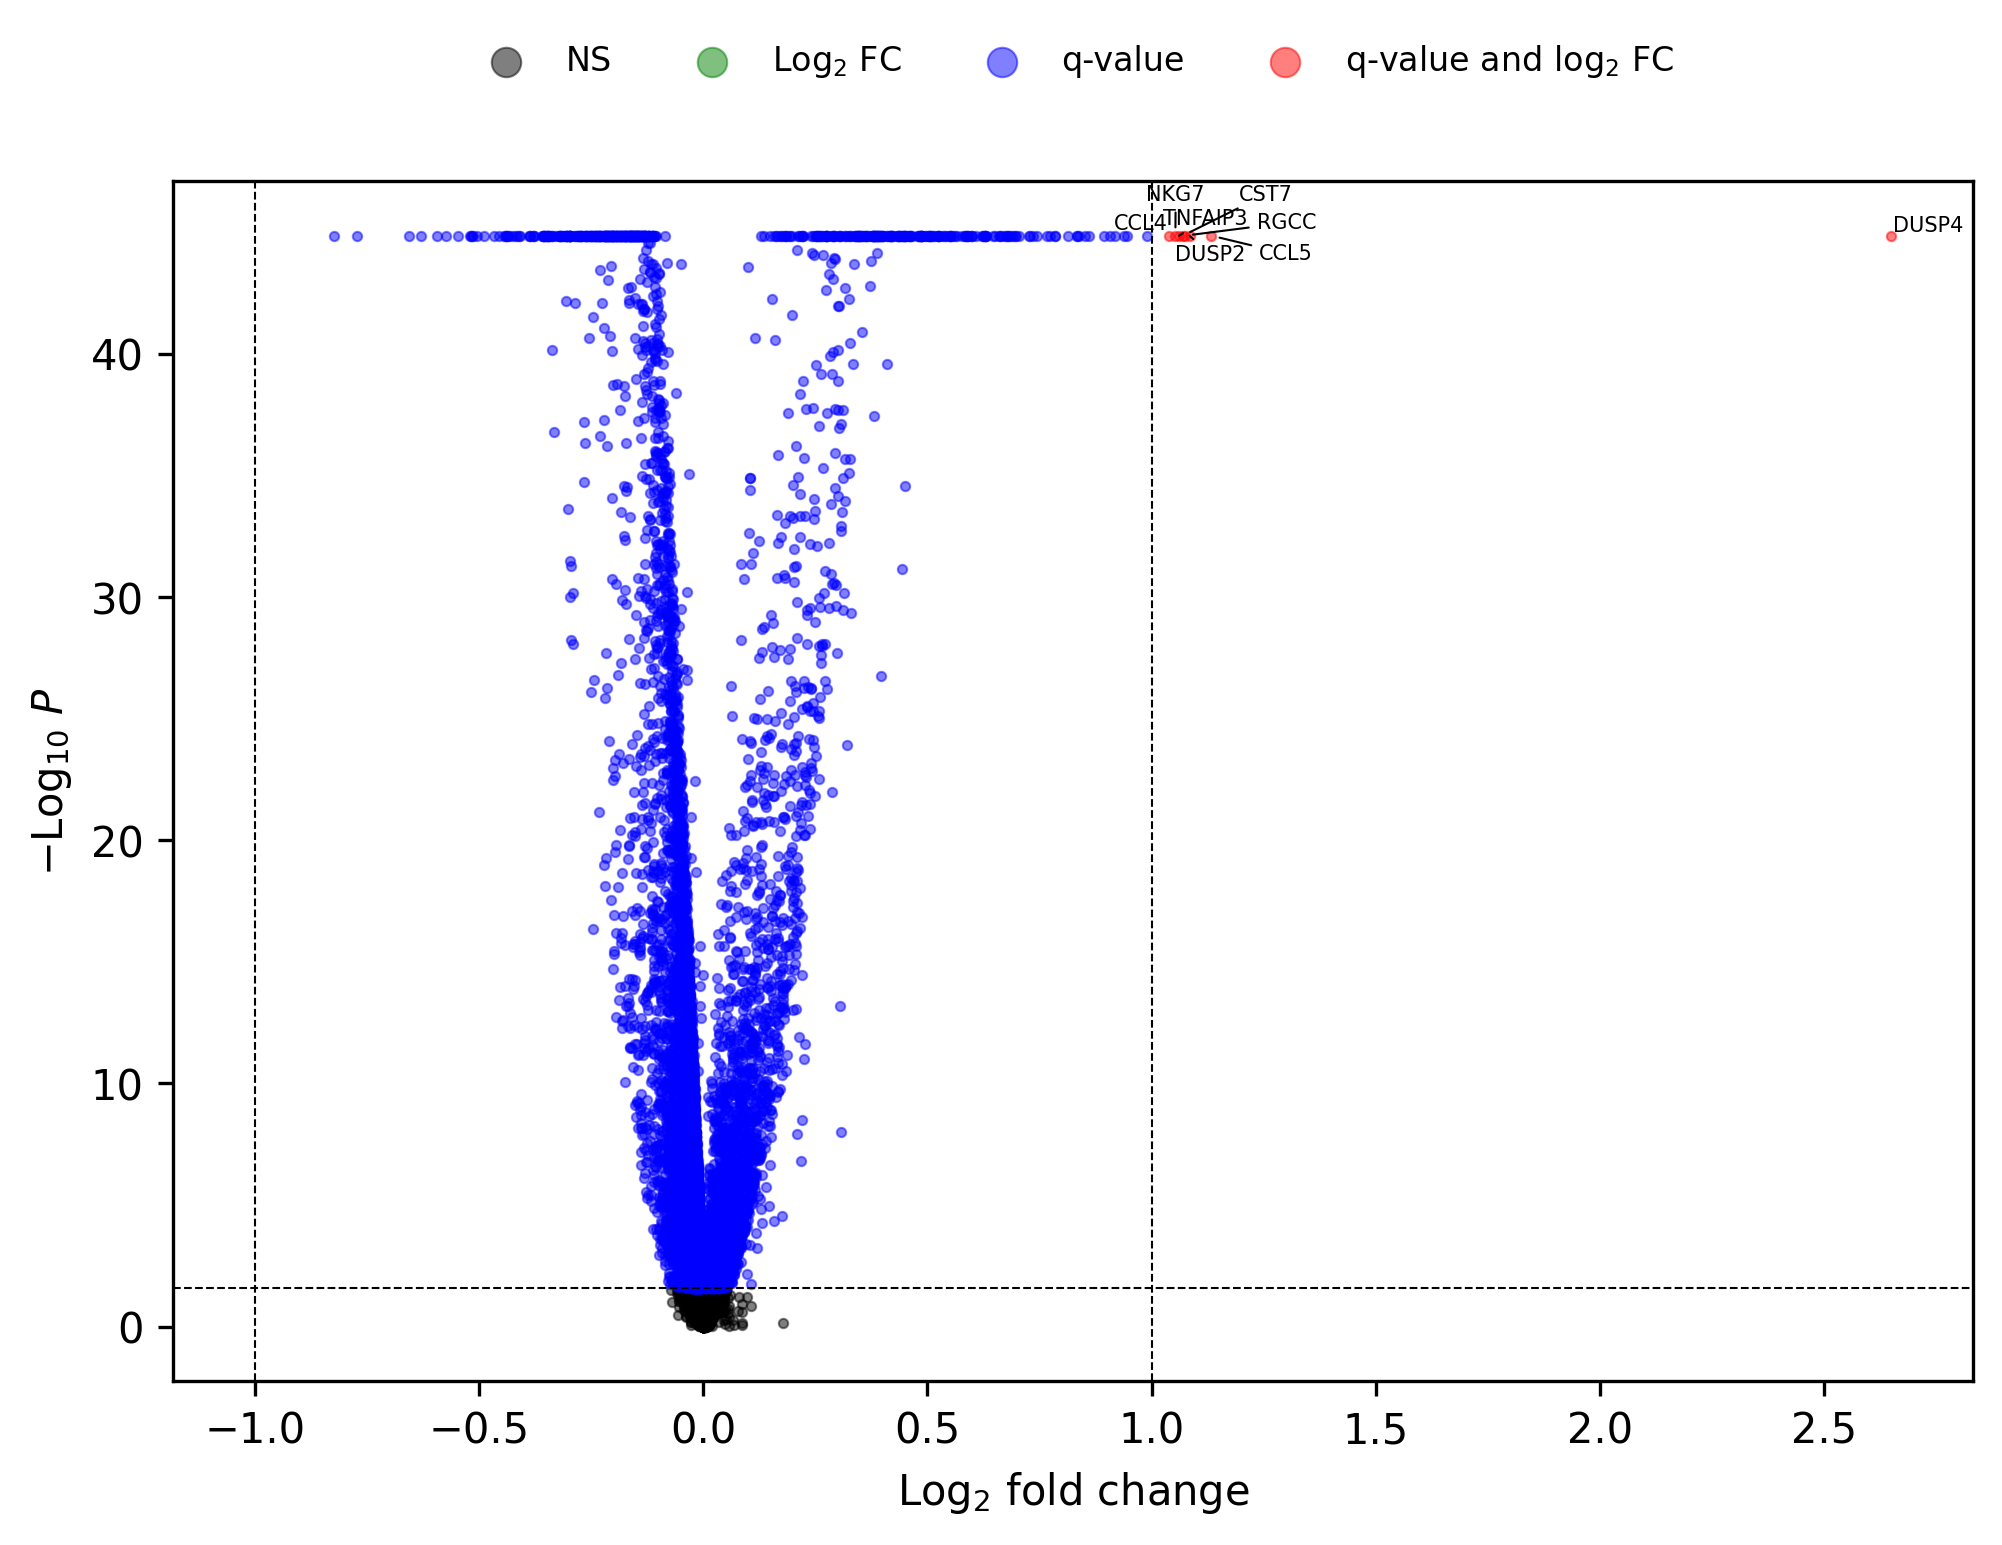

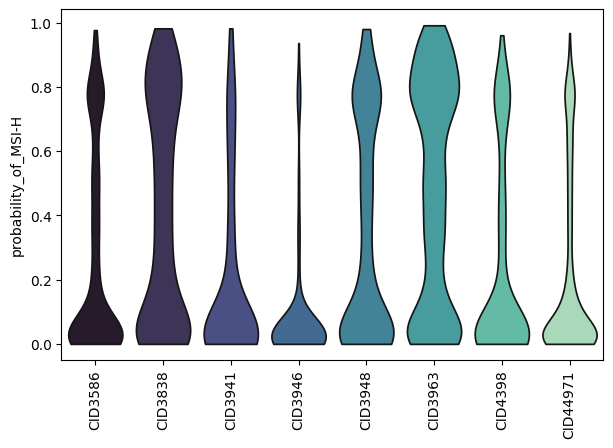

KeyError: "Could not find keys ['Immune_score'] in columns of `adata.obs` or in adata.var_names."

In [327]:
# Violin plots
sc.pl.violin(rna_filtered,
             'probability_of_MSI-H',
             color = patient_colors,
             groupby = 'patient',
             stripplot = False,
             jitter = .4,
             rotation = 90)
sc.pl.violin(rna_filtered, 'Immune_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = False,
             jitter = .4,
             rotation = 90)
sc.pl.violin(rna_filtered, 'Stromal_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = False,
             jitter = .4,
             rotation = 90)

In [ ]:
# umap msi sensor predicitions
sc.pl.umap(rna_filtered, color = 'msi_status',
           cmap = 'mako',
           title = 'UMAP MSI-sensor Prediction Status')

# comparing our score with the msi-sensor score
sns.scatterplot(x = rna_filtered.obs['MSI_score'],
                y = rna_filtered.obs['probability_of_MSI-H'],
                hue = rna_filtered.obs['patient'],
                palette = patient_colors, linewidth = 0,
                s = 4).set(title='MSI-Sensor/DEG Panel - MSI Prediction score')

# msi probabilty by patient (violin)
sc.pl.violin(rna_filtered, 'probability_of_MSI-H',
             groupby = 'patient',
             rotation = 90,
             stripplot = False,
             color = patient_colors).set(title='MSI-Sensor Probabiltity of MSI-H by Patient')

# msi probabilty by patient (barplot)
patient_msi = rna_filtered.obs.groupby('patient')['probability_of_MSI-H'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=patient_msi.index, y=patient_msi.values, ax=ax)
plt.title('Patient-level MSI Score (MSIsensor-RNA)')
plt.xticks(rotation=45)
plt.tight_layout()

In [351]:
from scipy import stats
# 
# stat = 'msi_score'
# stat2 = 'immune_score'
# 
# g1 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3586'])].obs[stat]
# g1_i = rna_filtered[rna_filtered.obs['patient'].isin(['CID3586'])].obs[stat2]
# g2 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3838'])].obs[stat]
# g3 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3941'])].obs[stat]
# g4 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3946'])].obs[stat]
# g5 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3948'])].obs[stat]
# g6 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3963'])].obs[stat]
# # print(g1)
# rna_filtered.obs.to_csv("data/rna_filtered.csv")
# 
# # rna_filtered.to_parquet("data/rna_filtered.parquet")
# print(stats.pearsonr(g1, g1_i))
# # plt.boxplot([g1, g2, g3, g4, g5, g6])
# plt.scatter(g1, g1_i, )
# statistic, p_value = stats.kruskal(g1, g2, g3, g4, g5, g6)
# print(statistic, p_value)
# print(rna_filtered.var_names)
print(stats.spearmanr(rna_filtered[:, rna_filtered.var_names == 'DUSP4'], rna_filtered.obs['probability_of_MSI-H']))

KeyboardInterrupt: 

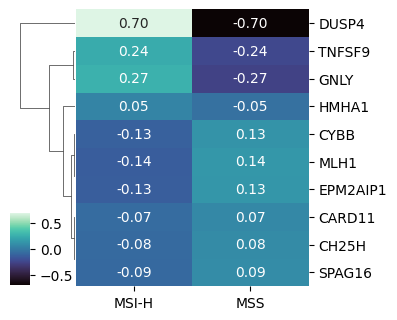

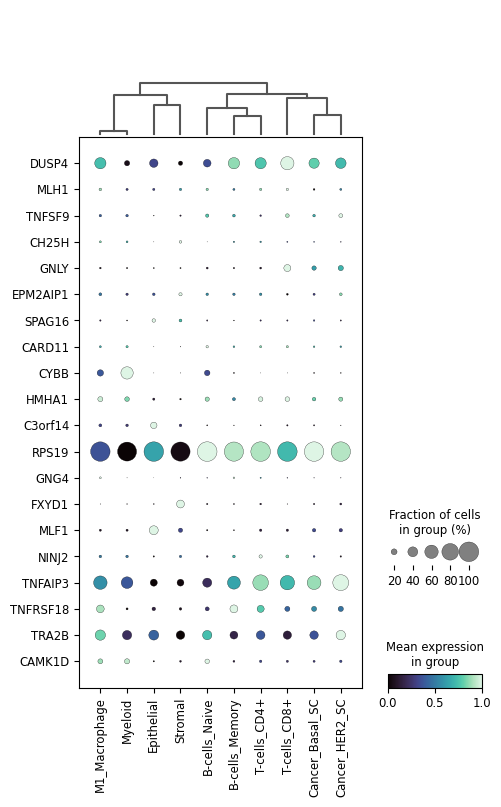

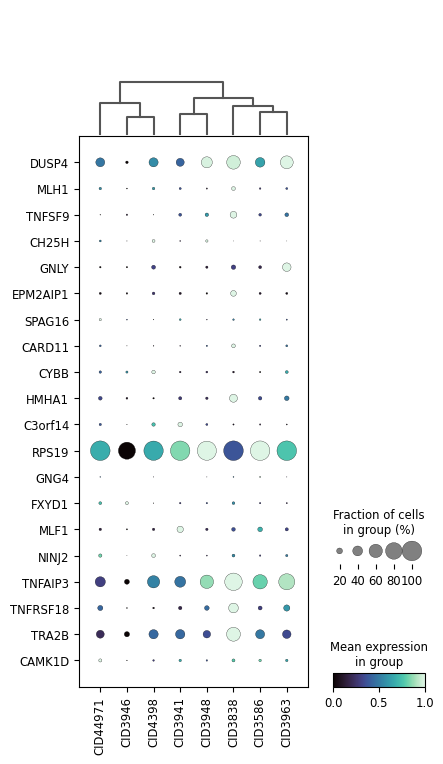

In [324]:
marker_genes =  xgb_markers
gene_df = pd.DataFrame(
    rna_filtered[:, marker_genes].X.toarray(),
    columns=marker_genes,
    index=rna_filtered.obs_names
)


status_df = pd.get_dummies(rna_filtered.obs['msi_status'])
combined_df = pd.concat([gene_df, status_df], axis=1)

corr_matrix = combined_df.corr()
gene_vs_status = corr_matrix.loc[marker_genes[0:10], status_df.columns]


cg = sns.clustermap(
    gene_vs_status,
    cmap='mako',
    center=0,
    annot=True,
    fmt=".2f",
    cbar_pos=(0.02, 0.1, 0.05, 0.18),
        figsize = (4,4)
)
# cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.set

# plt.title("Gene Markers vs Predicted Status Correlations")
plt.show()


sc.pl.dotplot(rna_for_de, marker_genes, cmap = 'mako',
              groupby = 'predicted_celltype',
              dendrogram = True,
              standard_scale = 'var',
              swap_axes = True)

sc.pl.dotplot(rna_for_de, marker_genes, cmap = 'mako',
              groupby = 'patient',
              dendrogram = True,
              standard_scale = 'var',
              swap_axes = True)

In [ ]:
plt.hist(g4)

CID3586_AAGACCTCAGCATGAG    0.0009
CID3586_AAGGTTCGTAGTACCT    0.0233
CID3586_ACTGATGGTCAACTGT    0.0093
CID3586_ACTTGTTAGGGAAACA    0.3610
CID3586_AGCAGCCTCCCTCTTT    0.0233
                             ...  
CID4398_TAGACCAAGCCCAGCT    0.0233
CID4398_TAGTTGGAGGGAAACA    0.6755
CID4398_TCAATCTAGCTCCTCT    0.0164
CID4398_TCAGGTAGTACTCAAC    0.3970
CID4398_TCTTTCCCAGTAAGCG    0.0103
Name: probability_of_MSI-H, Length: 17859, dtype: float64
Spearman Correlation: 0.7467197610285079
P-value in scientific notation: 0.0000000000000000e+00


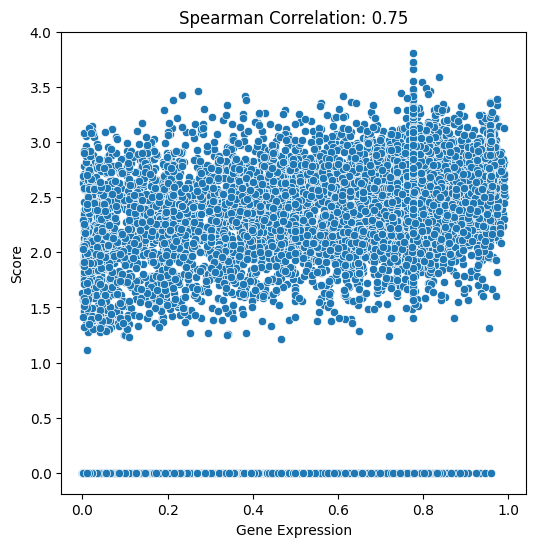

In [385]:
dusp4_exp = rna_filtered[:, 'DUSP4'].X.toarray().flatten()
score = rna_filtered.obs["probability_of_MSI-H"]  
print(score)

corr, p_value = stats.spearmanr(dusp4_exp, score)

print (f"spearman {corr:.3f} p-value {p_value}")

plt.figure(figsize=(6, 6))
sns.scatterplot(x=score, y=dusp4_exp)
plt.xlabel("Gene Expression")
plt.ylabel("Score")
plt.show()